X shape after features selection:  (307511, 143)
Train samples: (246008, 144), test samples: (61503, 144)
Preprocessing - done in 62s
Starting LightGBM. Train shape: (246008, 144), test shape: (61503, 144)
[200]	training's auc: 0.81646	training's binary_logloss: 0.535976	valid_1's auc: 0.77932	valid_1's binary_logloss: 0.542909
[400]	training's auc: 0.842082	training's binary_logloss: 0.513709	valid_1's auc: 0.786248	valid_1's binary_logloss: 0.52713
[600]	training's auc: 0.862664	training's binary_logloss: 0.490646	valid_1's auc: 0.789	valid_1's binary_logloss: 0.510122
[800]	training's auc: 0.879819	training's binary_logloss: 0.471174	valid_1's auc: 0.790411	valid_1's binary_logloss: 0.496332
[1000]	training's auc: 0.894182	training's binary_logloss: 0.454249	valid_1's auc: 0.790513	valid_1's binary_logloss: 0.48478
Fold  1 AUC : 0.790513
[200]	training's auc: 0.818264	training's binary_logloss: 0.534176	valid_1's auc: 0.769854	valid_1's binary_logloss: 0.544877
[400]	training's auc:

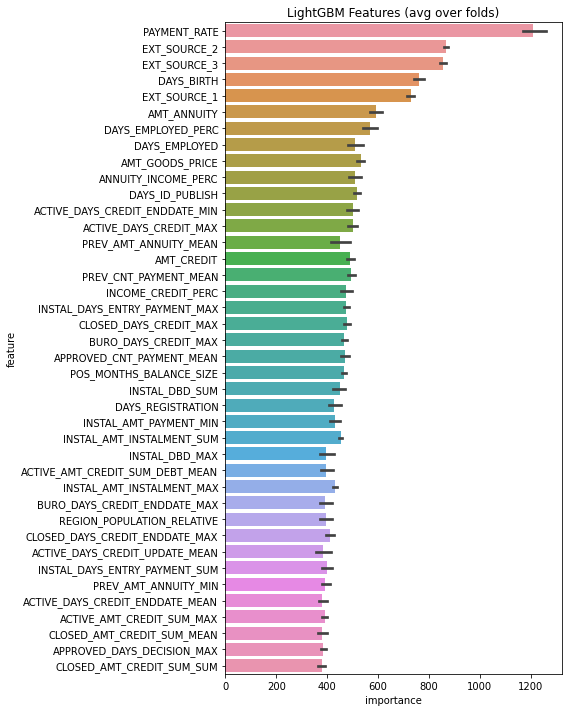

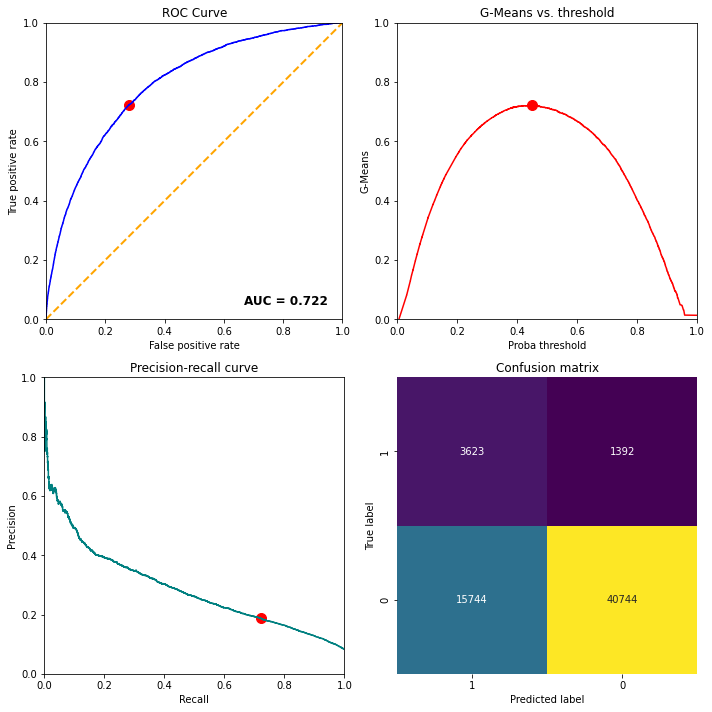

Run LightGBM with kfold - done in 359s
Full model run - done in 454s


In [104]:
import numpy as np
import pandas as pd
import gc
import time
import re 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,  StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn import metrics
from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


def preprocessing(df):
    # Read data
    
    df = df.replace([np.inf, -np.inf], np.nan)

    X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y = df['TARGET']


    # Categorical features with One-Hot encode
    categorical_features = X.select_dtypes(exclude=np.number).columns
    steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    categorical_transformer = Pipeline(steps=steps)

    # Numeric features with StandardScaler
    numeric_features = X.select_dtypes(include=np.number).columns
    steps = [('scaler', StandardScaler())]
    numeric_transformer = Pipeline(steps=steps)

    preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                    ])
    X = preprocessor.fit_transform(X)

    # Feature selection
    sfm = SelectFromModel(LGBMClassifier(n_jobs=-1))
   
    sfm.fit(X, y)
    X = sfm.transform(X)

    print('X shape after features selection: ', X.shape)

    # Export preprocessing in pkl
    with open('preprocessor', 'wb') as file:
        pickle.dump(preprocessor, file)

    with open('select_feat', 'wb') as file:
        pickle.dump(sfm, file)
    
    # Save feature names to future features importance eval
    onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].\
                          get_feature_names_out(input_features=categorical_features))
    numeric_features_list = list(numeric_features)
    feats = np.concatenate((numeric_features_list, onehot_columns))
    feats = feats[sfm.get_support()]

    df_encoded = pd.DataFrame(X, columns=feats)
    df_encoded['TARGET'] = df['TARGET']

    # Rename columns to avoid JSON character
    charac = ','
    charac_2 = ':'
    new_list = []
    for item in df_encoded.columns: 
        if (charac in item) | (charac_2 in item):
            item = re.sub(charac, '_', item)
            item = re.sub(charac_2, '_', item)
            new_list.append(item)
        else:
            new_list.append(item)
    df_encoded = df_encoded.set_axis(new_list, axis=1)

    # Train, Test split
    df_train, df_test = train_test_split(df_encoded,
                                         test_size=.2,
                                         random_state=123)

    print("Train samples: {}, test samples: {}".format(df_train.shape, df_test.shape))

    return df_train, df_test


def kfold_lightgbm(train_df, test_df, num_folds, debug=False):

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=123)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    y_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR']]
    
    fold_idx = folds.split(train_df[feats], train_df['TARGET'])
    for n_fold, (train_idx, valid_idx) in enumerate(fold_idx):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization

        clf = LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.02,
            colsample_bytree=0.2352167642701535,
            max_depth=9,
            min_child_weight=34.67802513470199,
            min_split_gain=0.772886577362599,
            num_leaves=44,
            reg_alpha=0.6466454272437308,
            reg_lambda=0.883716377059081,
            subsample=0.1498951237319723,
            scale_pos_weight=11.387150050352467,
            silent=-1,
            verbose=-1,
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        y_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    # Export model in pkl and plot feature importance
    print(len(clf.feature_importances_))
    with open('classifier', 'wb') as file:
        pickle.dump(clf, file)

    display_importances(feature_importance_df)
    evaluation(test_df, y_preds)
    
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('visualisation/lgbm_importances.png')

def evaluation(df_test, y_prob):

    y_test = df_test['TARGET']

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

    # calculate the g-mean for each threshold
    g_means = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(g_means)

    y_prob = (y_prob >= thresholds[ix]).astype(bool)

    tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
    print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
    conf_mat = [[tp,fn],[fp,tn]]

    auc = metrics.roc_auc_score(y_test, y_prob)
    recall = metrics.recall_score(y_test, y_prob)
    precision = metrics.precision_score(y_test, y_prob)
    f1 = metrics.f1_score(y_test, y_prob)

    ######################################
    print(f'Testset: \
    threshold = {thresholds[ix]:.0%}, \
    G-Mean= {g_means[ix]:.0%}, \
    AUC = {auc:.0%}, \
    recall= {recall:.0%}, \
    f1 = {f1:.0%}')
    ######################################

    # Evaluation plot
    plt.figure(figsize=(10, 10))

    # ROC curve
    plt.subplot(221)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, label='LightGBM', color='blue')
    plt.plot([0, 1], [0, 1], '--', lw=2, color='orange', label='no skill')
    plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
    plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
            fontsize=12, weight='bold')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

    # G-Means vs Threshold curve
    plt.subplot(222)
    plt.plot(thresholds, g_means, 'r')
    plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Proba threshold')
    plt.ylim(0,1)
    plt.ylabel('G-Means')
    plt.title('G-Means vs. threshold')

    # Precision recall curve 
    plt.subplot(223)
    plt.plot(recall_, precision_, 'teal')
    plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Recall')
    plt.ylim(0,1)
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')

    # Confusion matrix
    plt.subplot(224)
    sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=False, cmap='viridis')
    plt.xticks([0.5,1.5], [1,0])
    plt.yticks([0.5,1.5], [1,0])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    plt.tight_layout(pad=1.1)
    plt.show()

def main(debug = False):
    num_rows = 10000 if debug else None

    df = pd.read_csv('data/model_dataset.csv',
                nrows=num_rows,
                low_memory=False,
                verbose=False,
                encoding='ISO-8859-1',
                dtype={'Special': 'object'}
                )
    with timer("Preprocessing"):
        df_train, df_test = preprocessing(df)
        del df
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df_train, df_test, num_folds=5, debug=debug)

if __name__ == "__main__":
    with timer("Full model run"):
        main()

# Environment setup & graphical parameters

In [19]:
import numpy as np
import pandas as pd
import gc
import time
import re 
import pickle
from collections import Counter
import seaborn as sns
import warnings

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from contextlib import contextmanager
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore')


In [89]:
# Read data
df = pd.read_csv('data/model_dataset.csv',
                low_memory=False,
                verbose=False,
                encoding='ISO-8859-1',
                dtype={'Special': 'object'}
                )
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning - Encoding - TrainTest 

I will use lightGBM classifier as algotrithm as it is faster compare to XGBoost and RandomForest. 

In [50]:
# Preprocessing

def preprocessing(df, NaN_remove=False, impute=False, sampling=False, feat_select=False):
       t0 = time.time()

       df = df.replace([np.inf, -np.inf], np.nan)
       
       # Missing value -> Imputation
       if NaN_remove:
              df = df.dropna(axis = 0)
              df.shape

       # Definition of target and features variables

       X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
       y = df['TARGET']

       print('X shape before preprocessing: ', X.shape)
       print("Target distribution: {}".format(Counter(y)))

       # Encoding

       if impute:
              print('Impute =', impute)
              numeric_features = X.select_dtypes(include=np.number).columns
              steps = [('med_imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())
                     ]
              numeric_transformer = Pipeline(steps=steps)

              categorical_features = X .select_dtypes(exclude=np.number).columns
              steps=[('mode_imputer', SimpleImputer(strategy='most_frequent')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore'))]
              categorical_transformer = Pipeline(steps=steps)

              preprocessor = ColumnTransformer(
              transformers=[('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                            ])

              X = preprocessor.fit_transform(X)
              print('X shape: ', X.shape)

              if sampling:
                     print('Sampling =', impute)
                     # Sampling because of unbalance TARGET
                     over = SMOTE(sampling_strategy=0.1)
                     under = RandomUnderSampler(sampling_strategy=0.5)

                     steps = [('over', over),
                              ('under', under)
                            ]
                     sm = Pipeline(steps=steps)

                     X, y = sm.fit_resample(X, y)
                     print('X shape: ', X.shape)
                     print("Target distribution of {}: {}".format('y', Counter(y)))

       else:
              print('Impute =', impute)
              numeric_features = X.select_dtypes(include=np.number).columns
              steps = [('scaler', StandardScaler())]
              numeric_transformer = Pipeline(steps=steps)

              categorical_features = X .select_dtypes(exclude=np.number).columns
              steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
              categorical_transformer = Pipeline(steps=steps)

              preprocessor = ColumnTransformer(
              transformers=[('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                            ])

              X = preprocessor.fit_transform(X)
              print('X shape after preprocessing: ', X.shape)

       # Train, Test split
       onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].\
                            get_feature_names_out(input_features=categorical_features))
       numeric_features_list = list(numeric_features)
       feats = np.concatenate((numeric_features_list, onehot_columns))

       if feat_select: 
              print('Features selection')
              from sklearn.feature_selection import SelectFromModel

              sfm = SelectFromModel(LGBMClassifier(n_jobs=-1)).fit(X, y)
              X = sfm.transform(X)

              print('X shape after features selection: ', X.shape)

              feats = feats[sfm.get_support()]

       df_encoded = pd.DataFrame(X, columns=feats)
       df_encoded['TARGET'] = np.array(y)

       # Rename columns to avoid JSON character
       charac = ','
       charac_2 = ':'
       new_list = []
       for item in df_encoded.columns: 
              if (charac in item) | (charac_2 in item):
                     item = re.sub(charac, '_', item)
                     item = re.sub(charac_2, '_', item)
                     new_list.append(item)
              else:
                     new_list.append(item)
       df_encoded = df_encoded.set_axis(new_list, axis=1)

       df_train, df_test = train_test_split(df_encoded,
                                          test_size=.2,
                                          random_state=5)

       print(df_train.shape)
       print(df_test.shape)

       X_train = df_train.drop('TARGET', axis=1)
       y_train = df_train['TARGET']

       X_test = df_test.drop('TARGET', axis=1)
       y_test = df_test['TARGET']


       print("Preprocessing done in {:.0f}s".format(time.time() - t0))

       return X_train, y_train, X_test, y_test, feats

# Preprocessing evaluation

In [33]:
from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import warnings



X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 63s
Model evaluation


/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

DummyClassifier evaluation done in 10s
LGBMClassifier evaluation done in 88s


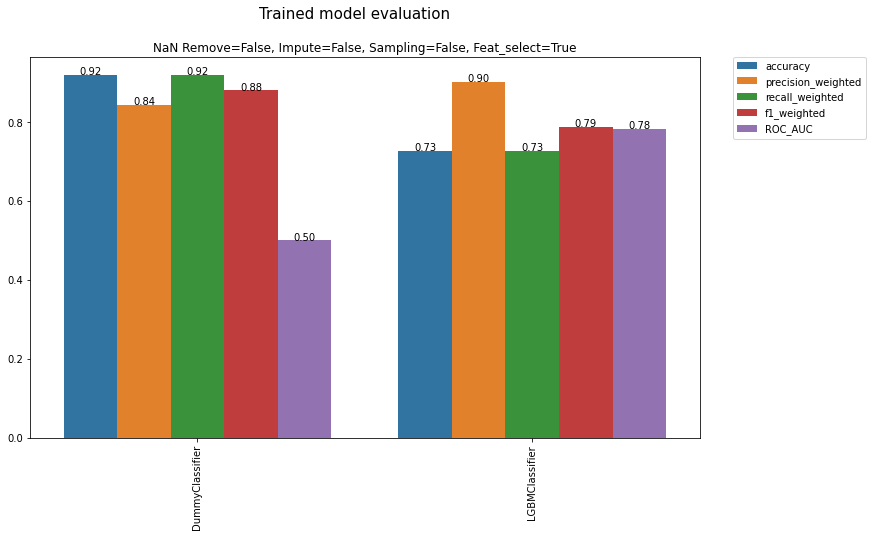

In [56]:
# Evaluation
warnings.filterwarnings('ignore')
t0 = time.time()
dfs = [] 
models = [
          ('DummyClassifier', DummyClassifier()),
          ('LGBMClassifier',LGBMClassifier(n_jobs=-1,
                                           scale_pos_weight=Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1])),
          #('LogisticRegression', LogisticRegression(n_jobs=-1)),
          #('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
        ]
results = []
names = []
scoring = {'accuracy': 'accuracy',
           'precision_weighted': 'precision_weighted',
           'recall_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted',
           'roc_auc': 'roc_auc'      
           }

# evaluate model
NaN_remove=False
impute=False
sampling=False
feat_select=True

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

print('Model evaluation')
for name, model in models:
    t0 = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    df_res = pd.DataFrame(scores)
    df_res['model'] = name
    df_res['imputed'] = impute
    df_res['sampling'] = sampling
    model.fit(X_train, y_train)
    dfs.append(df_res)
    ypred = model.predict(X_test)
    print("{} evaluation done in {:.0f}s".format(name, time.time() - t0))
final = pd.concat(dfs, ignore_index=True)

# Structure model score dataframe
eval=final[['model',
            'test_accuracy',
            'test_precision_weighted',
            'test_recall_weighted',
            'test_f1_weighted',
            'test_roc_auc']]
eval_ag=eval.groupby("model").mean()
eval_ag['model']=eval_ag.index
eval_ag.rename(columns={'test_roc_auc': 'ROC_AUC',
                        'test_accuracy':'accuracy',
                        'test_precision_weighted':'precision_weighted',
                        'test_recall_weighted':'recall_weighted',
                        'test_f1_weighted':'f1_weighted'},inplace=True)
stack=eval_ag.melt(id_vars=['model'])

# Plot model score
fig, axes= plt.subplots(figsize=(12,7))
plt.suptitle('Trained model evaluation', fontsize=15)
plt.title('NaN Remove={}, Impute={}, Sampling={}, Feat_select={}'.format(NaN_remove, impute, sampling, feat_select))
ax=sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.001,
            "%.2f" % p.get_height(),
            ha="center") 
    
for tick in ax.get_xticklabels():
        tick.set_rotation(90)  
plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05,1),loc=2,  borderaxespad=0.)
plt.draw()
plt.savefig('visualisation/Preprocess_eval_NaN-{}_Impute-{}_Sampling-{}_Fselect-{}.png'.format(NaN_remove, impute, sampling, feat_select),
            facecolor='w',
            edgecolor='w',
            bbox_inches='tight')


In [ ]:
# RFE CV feature selection

from sklearn.feature_selection import RFECV

estimator = LGBMClassifier()

min_features_to_select = 100  # Minimum number of features to consider
rfecv = RFECV(
    estimator=estimator,
    step=10,
    cv=StratifiedKFold(3),
    scoring=make_scorer(roc_auc_score),
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
    )
plt.show()

Learning Curve done in 20s


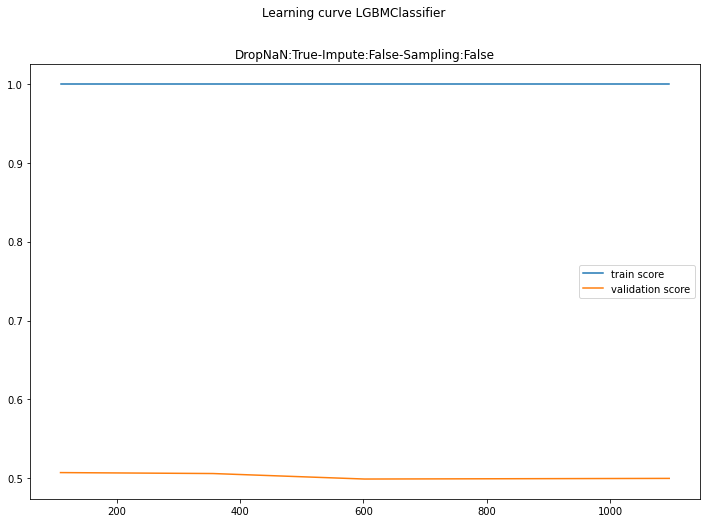

In [17]:
# Learning curve to evaluate over or underfitting
t0 = time.time()

models = [
          ('LGBMClassifier',LGBMClassifier()),
          #('LogisticRegression', LogisticRegression()),
          #('RandomForestClassifier', RandomForestClassifier()),
        ]

for name, model in models:
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=cv, scoring=make_scorer(roc_auc_score),
                                              train_sizes=np.linspace(0.1, 1, 5))


  plt.figure(figsize=(12, 8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.suptitle(f'Learning curve {name}')
  plt.title(f'DropNaN:{NaN_remove}-Impute:{impute}-Sampling:{sampling}')
  plt.legend()
  plt.savefig('LearningCurve_NaN-{}_Impute-{}_Sampling-{}.png'.format(NaN_remove, impute, sampling),
            facecolor='w',
            edgecolor='w',
            bbox_inches='tight')
  print("visualisation/Learning Curve done in {:.0f}s".format(time.time() - t0))

## Preprocessing conclusion

Evalation on preprocessing on tree algorithm : DummyClassifier, lightGBM, Logistic regression and Random Forrest to predict credit score. Default parameter are use for the classifier. 

For first trials, I use all the feature without any feature engineering

1. **Remove NaN + Encoding (cat:OH, num:StandScaler)**
    - X shape before preprocessing:  (1713, 431)
    - Target distribution of y: Counter({0: 1567, 1: 146})
    - Impute = False
    - X shape after preprocessing:  (1713, 526)
    - (1370, 527)
    - (343, 527)
    - Preprocessing done in 9s
    
    The best models were LBGMclassifier and Logistic regression with ROC-AUC = 0.68 and 0.56 respectively. The time to process is a few secondes. The learning curve on LGBMclassifier shows a overfitting of the model

2. **Keep NaN + Encoding (cat:OH, num:StandScaler)** (Only LightGBM can handle NaN)
    - X shape before preprocessing:  (307511, 431)
    - Target distribution of y: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 541)
    - (246008, 542)
    - (61503, 542)
    - Preprocessing done in 12s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process was 247 secondes. The learning curve on LGBMclassifier shows a overfitting of the model


3. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler)**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution of y: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape:  (307511, 539)
    - (246008, 540)
    - (61503, 540)
    - Preprocessing done in 53s

    The best models were LBGMclassifier and Logistic regression with ROC-AUC = 0.78 and 0.77, respectively. The time to process was 166s.


4. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + sampling SMOTE**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 539)
    - Sampling = True
    - X shape:  (84804, 539)
    - Target distribution of y: Counter({0: 56536, 1: 28268})
    - (67843, 540)
    - (16961, 540)
    - Preprocessing done in 82s

    The best models were LBGMclassifier and RandomForest with ROC-AUC = 0.81 and 0.78, respectively. The time to process is less than a minute. The learning curve shows no overfitting.

The sampling does not seems to be very effective, more over lightGBM classifier can handle unbalanced target. We will use this the preprocessing wihtout sampling to test features selection. 

5. **Keep NaN + Encoding (cat:OH, num:StandScaler) + Feature selection** (LightGBM only)
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 73s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is a one minutes.

6. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** 
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 539)
    - Features selection
    - X shape after features selection:  (307511, 130)
    - (246008, 131)
    - (61503, 131)
    - Preprocessing done in 101s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is a one minutes. 

7. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Sampling SMOTE + Feature selection**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 539)
    - Sampling = True
    - X shape:  (84804, 539)
    - Target distribution of y: Counter({0: 56536, 1: 28268})
    - Features selection
    - X shape after features selection:  (84804, 133)
    - (67843, 134)
    - (16961, 134)
    - Preprocessing done in 88s
    
    LBGMclassifier ROC-AUC = 0.80. The time to process is 30 secondes. 

8. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** for lightGBM with hyperparater 'unbalanced' = True
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 68s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is 100 secondes. 

9. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** for lightGBM with hyperparater 'scale_pos_weight'= Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1] ~ 10
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 68s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is 88 secondes. 

For the hyperparameter tuning I will use to preprocessing 6. because of ROC-AUC and Fbeta score whiche are high and the less preprocessing step. More over removing some features allows a faster modelisation without a lost in classification precision.


# Hyperparameters Tuning

In [59]:
# Bayesian Optimisation of lightGBM classifier Hyperparameter

import lightgbm
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

NaN_remove=False
impute=False
sampling=False
feat_select=True
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

def lgbm_eval(num_leaves,
              colsample_bytree,
              subsample,
              max_depth,
              reg_alpha,
              reg_lambda,
              min_split_gain,
              min_child_weight,
              ):

    lgbm_train = lightgbm.Dataset(X_train, y_train, params={'verbose': -1})
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
    cv_fold = fold.split(X_train, y_train)

    params = {'application':'binary',
              'n_estimators':1000,
              'learning_rate':0.02,
              'scale_pos_weight':weight,
              'nthread':-1,
              'verbose':-1
              } 

    params["num_leaves"] = int(num_leaves)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['subsample'] = max(min(subsample, 1), 0)
    params['max_depth'] = int(max_depth)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    clf = lightgbm.cv(params=params,
                      train_set=lgbm_train,
                      metrics=['auc'], 
                      folds=cv_fold, 
                      num_boost_round=100,
                      early_stopping_rounds=100,
                      verbose_eval=-1
                    )

    return clf['auc-mean'][-1]

clf_bo = BayesianOptimization(lgbm_eval, {'num_leaves': (30, 45),
                                          'colsample_bytree': (0.1, 1),
                                          'subsample': (0.1, 1),
                                          'max_depth': (5, 15),
                                          'reg_alpha': (0, 1),
                                          'reg_lambda': (0, 1),
                                          'min_split_gain': (0, 1),
                                          'min_child_weight': (30, 45)
                                        })

clf_bo.maximize(init_points=4, n_iter=20)



X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 64s
|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7873   |  0.852    |  9.513    |  34.2     |  0.1608   |  36.47    |  0.45     |  0.08428  |  0.6955   |
|  2        |  0.7874   |  0.1564   |  13.21    |  34.42    |  0.5256   |  39.84    |  0.4602   |  0.1847   |  0.2351   |
|  3        |  0.7879   |  0.2561   |  5.173    |  42.81    |  0.9898   |  31.39    |  0.0853   |  0.7511   |  0.5982   |
|  4        |  0.7873   |  0.6988   |  13.59    |  33.84    |  0.1364   |  36.66    |  0.4282   |  0.03223  |  0.

In [60]:
params_gbm = clf_bo.max['params']
params_gbm['max_depth'] = round(params_gbm['max_depth'])
params_gbm['num_leaves'] = round(params_gbm['num_leaves'])
params_gbm

{'colsample_bytree': 0.2352167642701535,
 'max_depth': 9,
 'min_child_weight': 34.67802513470199,
 'min_split_gain': 0.772886577362599,
 'num_leaves': 44,
 'reg_alpha': 0.6466454272437308,
 'reg_lambda': 0.883716377059081,
 'subsample': 0.1498951237319723}

In [105]:
# Research of best Hyperparamter with RandomSearch CV

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

n = 10
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

lgbm = LGBMClassifier(n_estimators=1000,
                      silent=-1,
                      verbose=-1,
                      metric='None',
                      n_jobs=-1,
                      application='binary',
                      learning_rate=0.02,
                      scale_pos_weight=weight,
                      )


lgbm_param = {'num_leaves': np.linspace(30, 45, 7, dtype='int'),
              'min_split_gain': stats.uniform(loc=0.1, scale=0.8),
              'min_child_weight': np.linspace(30, 45, 10),
              'subsample': stats.uniform(loc=0.1, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.1, scale=0.2),
              'max_depth': np.linspace(5, 15, 10, dtype='int'),
              'reg_alpha': np.linspace(0, 1, 10),
              'reg_lambda': np.linspace(0, 1, 10)}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.789
{'colsample_bytree': 0.2588042700910767, 'max_depth': 10, 'min_child_weight': 45.0, 'min_split_gain': 0.629529728284177, 'num_leaves': 35, 'reg_alpha': 0.0, 'reg_lambda': 0.3333333333333333, 'subsample': 0.7856487540697591}


# Model evaluation

In [90]:
# Fit the model with best params
NaN_remove=False
impute=False
sampling=False
feat_select=True
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

model = LGBMClassifier(
            application='binary',
            n_estimators=1000,
            learning_rate=0.02,
            colsample_bytree=0.2352167642701535,
            max_depth=9,
            min_child_weight=34.67802513470199,
            min_split_gain=0.772886577362599,
            num_leaves=44,
            reg_alpha=0.6466454272437308,
            reg_lambda=0.883716377059081,
            subsample=0.1498951237319723,
            scale_pos_weight=weight,
            silent=-1,
            verbose=-1,
            )
model.fit(X_train, y_train)

X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 72s


LGBMClassifier(application='binary', colsample_bytree=0.2352167642701535,
               learning_rate=0.02, max_depth=9,
               min_child_weight=34.67802513470199,
               min_split_gain=0.772886577362599, n_estimators=1000,
               num_leaves=44, reg_alpha=0.6466454272437308,
               reg_lambda=0.883716377059081,
               scale_pos_weight=11.387150050352467, silent=-1,
               subsample=0.1498951237319723, verbose=-1)

TN = 40330, FP = 16309, FN = 1332, TP = 3532
Testset: threshold = 45%, G-Mean = 72%, AUC = 72%, recall = 73%, precision = 18%, f1 = 29%


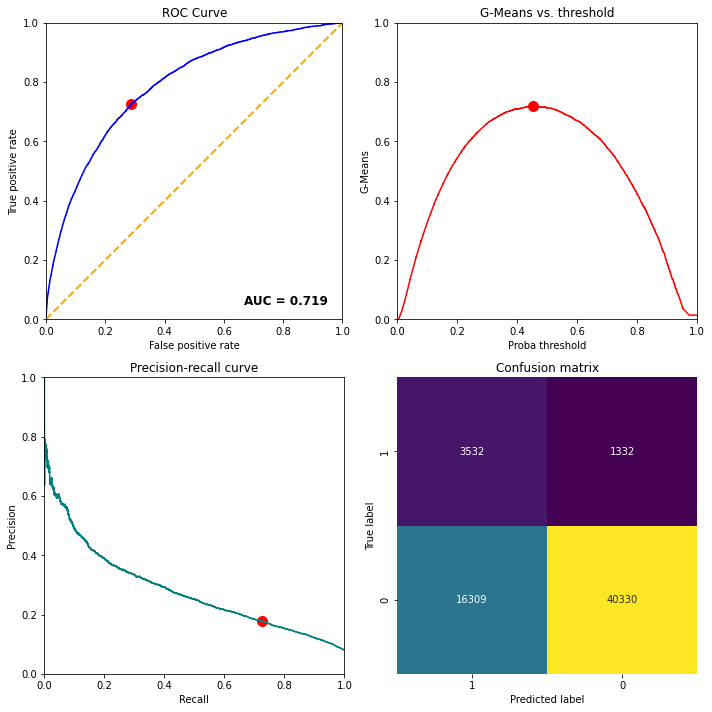

In [91]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics


# predict probabilities
y_prob = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean = {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall = {recall:.0%}, \
precision = {precision:.0%}, \
f1 = {f1:.0%}')
######################################

# Evaluation plot
plt.figure(figsize=(10, 10))

# ROC curve
plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, label='LightGBM', color='blue')
plt.plot([0, 1], [0, 1], '--', lw=2, color='orange', label='no skill')
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=12, weight='bold')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

# G-Means vs Threshold curve
plt.subplot(222)
plt.plot(thresholds, g_means, 'r')
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

# Precision recall curve 
plt.subplot(223)
plt.plot(recall_, precision_, 'teal')
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

# Confusion matrix
plt.subplot(224)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=False, cmap='viridis')
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

# Interpretability of the model

In [65]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()

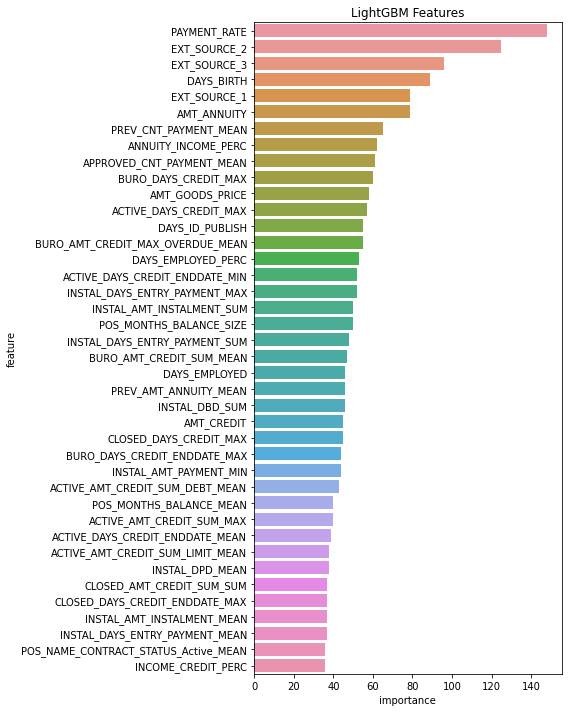

In [66]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = model.feature_importances_
feature_importance_df = pd.DataFrame()
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

display_importances(feature_importance_df)

In [67]:
# importing the libraries
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'No Difficulties', 1:'Payement Difficulties'}

In [68]:
# create the LIME explainer
# add the class names for interpretability
X_train = np.array(X_train)
X_test = np.array(X_test)
LIME_explainer = lime_tabular.LimeTabularExplainer(X_train, class_names=class_names, feature_names=feats)


In [69]:

idx = np.random.randint(1, len(X_test))

print('0 = No Difficulties, 1 = Payement Difficulties')
print("Prediction : ", model.predict(X_test[idx].reshape(1,-1))[0])
print("Actual :     ", np.array(y_test)[idx])

explanation = LIME_explainer.explain_instance(X_test[idx], model.predict_proba,
                                              num_features=20)

explanation.show_in_notebook()



0 = No Difficulties, 1 = Payement Difficulties
Prediction :  0
Actual :      0


In [75]:
# importing SHAP
import shap

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 100)
X_test_sample = shap.sample(X_test, 20)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample)

100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


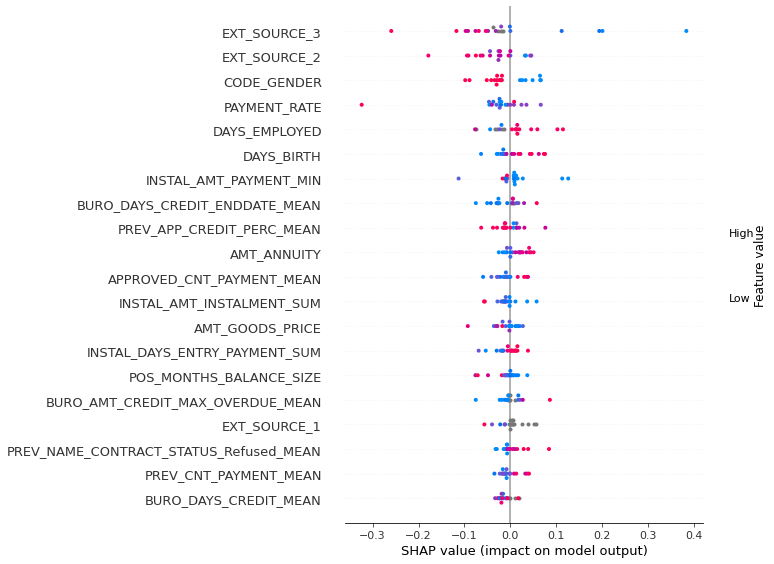

In [76]:
shap.summary_plot(shap_vals, colour_test, feature_names=feats)

In [77]:
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], 
                colour_test.iloc[1,:], feature_names=feats)